In [8]:
#Download the data 

import os
import tarfile
import urllib
import pandas as pd
#Where we download the data from
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
#Puts hosuing in the datasets folder
HOUSING_PATH = os.path.join("datasets", "housing")
#
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

#Now when you call fetch_housing_data(), it creates a datasets/housing directory in your workspace,
#downloads the housing.tgz file, and extracts the housing.csv file from it in this directory.

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    #Makes a new directory. 
    os.makedirs(housing_path, exist_ok=True)
    # Join one or more path components intelligently. The return value is the concatenation of path 
    #and any members of *paths with exactly one directory separator following each non-empty part 
    #except the last, meaning that the result will only end in a separator if the last part is empty.
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [110]:




fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


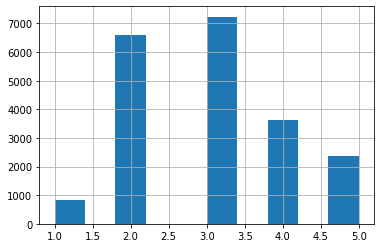

In [111]:
# we need to handle the income category 
#The following code uses the pd.cut()
#function to create an income category attribute with five categories (labeled from 1 to 5):
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [112]:
# Now we make sure we stratify our data 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [113]:
#Let’s see if this worked as expected. You can start by looking at the income category proportions in the test set:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)
#Since this matches our graph we should be fine. 

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [114]:
# Now you should remove the income_cat attribute so the data is back to its original state:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [115]:
# The attribute combinations used in the notes 
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [116]:
#median house value is the response variable so we get rid of it
# strat_train_set was declared when we stratified the data.
housing = strat_train_set.drop("median_house_value", axis=1)

#Copy the dats the originals set is fine
#More so, housing_labels is our response
housing_labels = strat_train_set["median_house_value"].copy()

In [117]:
#Neatly takes care of missing values 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# Since the median can only be computed on numerical attributes, 
# you need to create a copy of the data without the text attribute ocean_proximity:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [118]:
#Now you can use this “trained” imputer to transform 
#the training set by replacing missing values with the learned medians:
X = imputer.transform(housing_num)

In [119]:
#If you want to put it back into a pandas DataFrame, it’s simple:
#create a new data fram with the information
#.columns gets the columns of housing_num
#.index gets the index
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

# Adding attributes 


In [120]:
#We can add extra categories from ordinal (categorical) data
#First we grab only the categroies as a DF
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [121]:
#Ordinal encoder translates categorical variables 
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]
#Ordinal encoder went ahead and mapped the categories to some number.

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [122]:
#Likewise we can chose to use a binary method. This will make len(DF["category_column"].values) new columns
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

## Custom Transformers 

In the book we used a custom transformer to add a few attributes that might enhance our modeling.

In [123]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [124]:
# In python is a class both the class and ctr. 
#How do we overload this in Python?
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6 #Saves th index location of certain columns in the housing DF
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    #Would we overload the constructor here?
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room # is a boolean 
    def fit(self, X, y=None):
        return self  #Since we are only transforming, we do not need to fill in the fit method
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix] #Gets all rows of the column_index
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room: #if true
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room] # numpy.c_ :Translates slice objects to concatenation along the second axis. 

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Pipelines

Rather than do everystep in individual boxes, we can use a pipeline for ease of use.

In [129]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        #First we use the imputer to get rid of NAns
        ('imputer', SimpleImputer(strategy="median")),
        #Next we use the custom transformer to enchance the data set. 
        ('attribs_adder', CombinedAttributesAdder()),
        #Next we scale the data as some algorithms do not work well when 
        #the input numerical attributes have very different scales
        ('std_scaler', StandardScaler()),
    ])

#Pipelines make it easy to implement the code. Of course the above code was to develop this. 
housing_num_tr = num_pipeline.fit_transform(housing_num)


In [130]:
#We can also pipeline a pipeline. 
#Since the num_pipeline only handles numerical values, we need to handle the categorical variables from sklearn.compose import ColumnTransformer

#Sklearn has a module to pipeline all columns
from sklearn.compose import ColumnTransformer

#When working with this pipeline we need the column names

#This is a convient way to get the columns.
#Housing_num contains to categorical columns
num_attribs = list(housing_num)

#The only categorical column or orginal DF should have
cat_attribs = ["ocean_proximity"]


full_pipeline = ColumnTransformer([
            #Name the pipeline, the method/transformer/pipeline to use, what to use it on
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

#Apply it ot the housing dataset 
housing_prepared = full_pipeline.fit_transform(housing)

# Model training
## Exercise 1

In [42]:
from sklearn.svm import SVR
svr = SVR(kernel="linear")
#housing_prepared is the, cleaned and enchanced DF.
#housing_labels is our response column
svr.fit(housing_prepared, housing_labels)
#This trains the model which can make predictions 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [43]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", svr.predict(some_data_prepared))
print("Labels:", list(some_labels))
#This is terribly off to begin with

Predictions: [175421.01071251 190268.74555128 175653.26689489 165556.9789596
 183911.42788418]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [44]:
#Measuring the error for the entire set
from sklearn.metrics import mean_squared_error
housing_predictions = svr.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse
#Significantly off

111094.6308539982

In [45]:
#rbf is the default
svr = SVR(kernel="rbf")
#housing_prepared is the, cleaned and enchanced DF.
#housing_labels is our response column
svr.fit(housing_prepared, housing_labels)
#This trains the model which can make predictions 
housing_predictions = svr.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse
#Significantly off

118580.68301157995

In [47]:
#Messing with the gamma


#rbf is the default
svr = SVR(kernel="rbf", gamma='auto')
#housing_prepared is the, cleaned and enchanced DF.
#housing_labels is our response column
svr.fit(housing_prepared, housing_labels)
#This trains the model which can make predictions 
housing_predictions = svr.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse
#Significantly off

118577.43356412371

In [48]:
#Messing with the C


#rbf is the default
#Scale is defualt
# C =1 is defauly]t
svr = SVR(kernel="rbf", gamma='scale', C = 2.0)
#housing_prepared is the, cleaned and enchanced DF.
#housing_labels is our response column
svr.fit(housing_prepared, housing_labels)
#This trains the model which can make predictions 
housing_predictions = svr.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse
#Significantly off

118226.98577896513

In [100]:
#Solution from book
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   8.8s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   8.1s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   7.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.0s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=  10.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   8.8s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.3s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=  15.0s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  14.3s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  13.6s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=  13.3s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................


KeyboardInterrupt: 

In [ ]:
#This is much easier with grid search
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

In [ ]:

grid_search.best_params_

Kernal =Linear worked best. We cannot mess with gamma in the linear case

# Exercise 2 Try replacing GridSearchCV with RandomizedSearchCV.

For trying different combinations of hyper parameters, all you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. 

In [50]:
#First they tried to use another model
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_reg_mse = mean_squared_error(housing_labels, housing_predictions)
forest_reg_rmse = np.sqrt(forest_reg_mse)
forest_reg_rmse
#Much better than an SVR

18660.507950144554

In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [52]:
#Then we can get the best model
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [55]:
#Next we need to see the RMSE for the models 
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64393.898418595985 {'max_features': 2, 'n_estimators': 3}
55544.30776869036 {'max_features': 2, 'n_estimators': 10}
52926.884471275574 {'max_features': 2, 'n_estimators': 30}
59385.984636021516 {'max_features': 4, 'n_estimators': 3}
53181.674170222745 {'max_features': 4, 'n_estimators': 10}
50711.46957844601 {'max_features': 4, 'n_estimators': 30}
58337.90570720766 {'max_features': 6, 'n_estimators': 3}
52388.4993668803 {'max_features': 6, 'n_estimators': 10}
50238.539274394854 {'max_features': 6, 'n_estimators': 30}
58909.88347281292 {'max_features': 8, 'n_estimators': 3}
51866.484392218095 {'max_features': 8, 'n_estimators': 10}
50038.526261904124 {'max_features': 8, 'n_estimators': 30}
62653.561155716285 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54363.97557758518 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61072.181118138 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52741.61345900205 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [53]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

random_search = RandomizedSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

random_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [54]:
random_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

{'n_estimators': 30, 'max_features': 8}

In [56]:
#Next we need to see the RMSE for the models 
rmses = random_search.cv_results_
for mean_score, params in zip(rmses["mean_test_score"], rmses["params"]):
    print(np.sqrt(-mean_score), params)
#It managed to find a better model! 

52446.363555246826 {'n_estimators': 10, 'max_features': 8}
50255.752209280734 {'n_estimators': 30, 'max_features': 6}
50111.06131725529 {'n_estimators': 30, 'max_features': 8}
59052.461808108725 {'n_estimators': 3, 'max_features': 4, 'bootstrap': False}
52477.975204757044 {'n_estimators': 10, 'max_features': 4, 'bootstrap': False}
53020.33475491836 {'n_estimators': 30, 'max_features': 2}
51504.72324927583 {'n_estimators': 10, 'max_features': 6}
58793.20439649452 {'n_estimators': 3, 'max_features': 8}
55702.30177306523 {'n_estimators': 10, 'max_features': 2}
50909.97654544978 {'n_estimators': 30, 'max_features': 4}


In [57]:
#Since we have our best models we can look at features that are important 

#Grid_search 
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3528826866529892, 'median_income'),
 (0.16222607925956448, 'INLAND'),
 (0.11412153068915319, 'pop_per_hhold'),
 (0.07045794544674386, 'longitude'),
 (0.06801698424450403, 'latitude'),
 (0.06426612178491156, 'bedrooms_per_room'),
 (0.057341764178743385, 'rooms_per_hhold'),
 (0.04142214828149238, 'housing_median_age'),
 (0.014961186886030172, 'total_bedrooms'),
 (0.014568307434873608, 'population'),
 (0.014473591492776324, 'total_rooms'),
 (0.01413325121571032, 'households'),
 (0.0061086586717591755, '<1H OCEAN'),
 (0.002755878185539272, 'NEAR OCEAN'),
 (0.00213924054095453, 'NEAR BAY'),
 (0.00012462503425450996, 'ISLAND')]

In [58]:
#Since we have our best models we can look at features that are important 

#random_search 
feature_importances = random_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.35329948315106624, 'median_income'),
 (0.16903538612487937, 'INLAND'),
 (0.11435858611448066, 'pop_per_hhold'),
 (0.06962348283488266, 'bedrooms_per_room'),
 (0.06674186876635067, 'longitude'),
 (0.06443232854782972, 'latitude'),
 (0.05213680132899528, 'rooms_per_hhold'),
 (0.041287177414318164, 'housing_median_age'),
 (0.014924176056648192, 'population'),
 (0.01488079666825658, 'total_rooms'),
 (0.014563895999280754, 'households'),
 (0.01456301139087125, 'total_bedrooms'),
 (0.004780827247313626, '<1H OCEAN'),
 (0.0035316495260256783, 'NEAR OCEAN'),
 (0.0017494045716299452, 'NEAR BAY'),
 (9.112425717113587e-05, 'ISLAND')]

In [ ]:
# Github Solution
#Do not run it will take a long assss time
'''
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)
'''

The feature importance tells us that only one categorical predictor really matters. That is Inland, we can drop the other categoricals.

# Exercise 3 Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [69]:
#Using the values method allows us to easily grab certain columns and their values
housing.values[:,0]

array([-121.89, -121.93, -117.2, ..., -116.4, -118.01, -122.45],
      dtype=object)

In [71]:
housing.columns
#starts with the natural numbers

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [91]:
#[0] allows us to manpulate the array
cat_encoder.categories_[0]

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [93]:
#This does the trick
np.delete(cat_encoder.categories_[0], 1, 0)

array(['<1H OCEAN', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)

In [94]:
#This does the trick
list(np.delete(cat_encoder.categories_[0], 1, 0))

['<1H OCEAN', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [95]:
#My attempt didn't work. Past this is the github solution

#We need the most important features. 
#Idea have it do thru the zip above if the value is less than 4, we remove it from the data set

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6 #Saves th index location of certain columns in the housing DF
class removeAttributes(BaseEstimator, TransformerMixin):
    #Would we overload the constructor here?
    def __init__(self, good_attributes=True): # no *args or **kargs
        self.good_attributes = good_attributes # is a boolean 
    def fit(self, X, y=None):
        return self  #Since we are only transforming, we do not need to fill in the fit method
    def transform(self, X):
        if(self.good_attributes):
            to_drop = list(np.delete(cat_encoder.categories_[0], 1, 0))
            #I think X is an numpy array so this will not work 
            return X.drop(to_drop, axis =1)


#First we make a pipeline that will do all the prior steps and drop a few columns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    
    
        #We use the imputer to get rid of NAns   
        ('imputer', SimpleImputer(strategy="median")),
        #Next we use the custom transformer to enchance the data set. 
        ('attribs_adder', CombinedAttributesAdder()),
        #Next we scale the data as some algorithms do not work well when 
        #the input numerical attributes have very different scales
        ('std_scaler', StandardScaler()),
    ])

#Pipelines make it easy to implement the code. Of course the above code was to develop this. 
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [131]:
#now we go back to Pipelines 

from sklearn.base import BaseEstimator, TransformerMixin

#what I wanted to do was remove any value less that 4. 
#He selects the first k feautres
def indices_of_top_k(arr, k):
    #Perform an indirect partition along the given axis using the algorithm specified by the kind keyword.
    #It returns an array of indices of the same shape as a that index data along the given axis in partitioned order.
    #np.array(arr) is the thing we sort. 
    #Anything after k is what we get rid of. 
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]
#Note: this feature selector assumes that you have already computed the feature importances
# You may be tempted to compute them directly in the TopFeatureSelector's fit() method,
#however this would likely slow down grid/randomized search since the feature importances

In [132]:
#Speficify the steps we want to keep
k = 5
#feature_importances = grid_search.best_estimator_.feature_importances_ 
#It was called before the zip to display model results
#Sorts on a numerical value
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12], dtype=int64)

In [133]:
#attributes is defined in the model result section
#attributes was sorted on the top indices 
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'pop_per_hhold', 'bedrooms_per_room',
       'INLAND'], dtype='<U18')

In [134]:

sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.35329948315106624, 'median_income'),
 (0.16903538612487937, 'INLAND'),
 (0.11435858611448066, 'pop_per_hhold'),
 (0.06962348283488266, 'bedrooms_per_room'),
 (0.06674186876635067, 'longitude')]

In [135]:
#Now that we can manipulte the materials lets do the pipeline
preparation_and_feature_selection_pipeline = Pipeline([
    #The full pipeline cleans, adds and more.
    ('preparation', full_pipeline),
    #We just need to keep the "good" features
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [136]:
#If there is an issue with this step go back to the notes and re-run the pipelines
#I had an issue and it was due to me running what I tried for this exercise
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [137]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

In [138]:

housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

# 4. Try creating a single pipeline that does the full data preparation plus the final prediction.

In [139]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    #('svm_reg', SVR(**rnd_search.best_params_)) #He ran his with th random_search. We will not as it took too long
    ('svm_reg', SVR(**grid_search.best_params_)) #Our take forever too! This would word but we didn't finish out method.
])


prepare_select_and_predict_pipeline.fit(housing, housing_labels)

some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

This is pretty much it, it would lower the result significantly

# 5. Automatically explore some preparation options using GridSearchCV.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

In [ ]:

grid_search_prep.best_params_